# Mining Big Data - Assignment 3: Pattern Mining (Advanced)
# ===================================================

# Notebook 2: Advanced Pattern Mining Techniques and Optimizations

## 1. Introduction

This notebook explores advanced pattern mining techniques with a focus on efficiency and optimization. We'll cover:
- Performance comparisons between Apriori and FP-Growth
- Memory optimization techniques
- Advanced metrics for association rule evaluation
- Custom pattern mining implementation

## 2. Import Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules
from mlxtend.preprocessing import TransactionEncoder
import time
import os
import psutil
import gc
from itertools import combinations
from collections import defaultdict, Counter

## 3. Memory Management Functions

In [3]:
def get_memory_usage():
    """Return current memory usage in MB."""
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    memory_mb = memory_info.rss / (1024 * 1024)
    return memory_mb

def print_memory_usage(label):
    """Print memory usage with a label."""
    memory_mb = get_memory_usage()
    print(f"{label}: {memory_mb:.2f} MB")
    
def optimize_memory():
    """Force garbage collection to free memory."""
    gc.collect()
    print_memory_usage("Memory after optimization")

## 4. Load and Preprocess Data

In [4]:
# Load dataset
train_path = os.path.join('../dataset', 'train.csv')
train_data = pd.read_csv(train_path)

print(f"Dataset shape: {train_data.shape}")
print_memory_usage("Memory after loading data")

def optimize_dataframe(df):
    """Optimize dataframe memory usage by converting dtypes."""
    df_optimized = df.copy()
    
    # Optimize numeric columns
    int_columns = df_optimized.select_dtypes(include=['int']).columns
    for col in int_columns:
        df_optimized[col] = pd.to_numeric(df_optimized[col], downcast='integer')
    
    # Optimize float columns
    float_columns = df_optimized.select_dtypes(include=['float']).columns
    for col in float_columns:
        df_optimized[col] = pd.to_numeric(df_optimized[col], downcast='float')
    
    # Optimize object columns
    object_columns = df_optimized.select_dtypes(include=['object']).columns
    for col in object_columns:
        if df_optimized[col].nunique() / len(df_optimized) < 0.5:  # If low cardinality
            df_optimized[col] = df_optimized[col].astype('category')
    
    return df_optimized

# Optimize dataframe
train_data = optimize_dataframe(train_data)
print_memory_usage("Memory after optimization")

# Preprocess data - clean and prepare for mining
def preprocess_data(data):
    """Preprocess transaction data for pattern mining."""
    # Handle missing values
    df = data.dropna(subset=['itemDescription'])
    
    # Create transaction lists
    transactions = df.groupby('User_id')['itemDescription'].apply(list).to_dict()
    
    # Clean transactions (remove any remaining NaNs)
    cleaned_transactions = []
    for transaction in transactions.values():
        cleaned_transaction = [item for item in transaction if isinstance(item, str) and pd.notna(item)]
        if cleaned_transaction:
            cleaned_transactions.append(cleaned_transaction)
    
    print(f"Prepared {len(cleaned_transactions)} transactions")
    return cleaned_transactions

# Preprocess data
transactions = preprocess_data(train_data)
print_memory_usage("Memory after preprocessing")

Dataset shape: (26985, 7)
Memory after loading data: 212.46 MB
Memory after optimization: 212.26 MB
Prepared 3493 transactions
Memory after preprocessing: 213.42 MB


## 5. Encode Transactions

In [5]:
# Encode transactions
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
encoded_data = pd.DataFrame(te_ary, columns=te.columns_)

print(f"Encoded data shape: {encoded_data.shape}")
print_memory_usage("Memory after encoding")

# Memory optimization: convert to sparse matrix if needed
from scipy import sparse

def convert_to_sparse(df):
    """Convert DataFrame to sparse matrix if beneficial."""
    density = df.values.sum() / (df.shape[0] * df.shape[1])
    print(f"Data density: {density:.4f}")
    
    if density < 0.2:  # If sparse data (less than 20% filled)
        sparse_matrix = sparse.csr_matrix(df.values)
        print(f"Converted to sparse matrix of shape {sparse_matrix.shape}")
        return sparse_matrix
    else:
        print("Data not sparse enough to benefit from sparse representation")
        return df.values

# Check if sparse conversion would be beneficial
sparse_data = convert_to_sparse(encoded_data)
print_memory_usage("Memory after sparse conversion check")

Encoded data shape: (3493, 167)
Memory after encoding: 213.43 MB
Data density: 0.0314
Converted to sparse matrix of shape (3493, 167)
Memory after sparse conversion check: 213.47 MB


## 6. Algorithm Performance Comparison


Testing with min_support=0.05
Memory after optimization: 213.48 MB
Memory after optimization: 213.55 MB
Apriori: 0.06s, FP-Growth: 0.12s
Apriori found 38 itemsets, FP-Growth found 38 itemsets

Testing with min_support=0.02
Memory after optimization: 214.85 MB
Memory after optimization: 214.86 MB
Apriori: 0.07s, FP-Growth: 0.48s
Apriori found 144 itemsets, FP-Growth found 144 itemsets

Testing with min_support=0.01
Memory after optimization: 216.88 MB
Memory after optimization: 216.91 MB
Apriori: 0.12s, FP-Growth: 1.63s
Apriori found 383 itemsets, FP-Growth found 383 itemsets


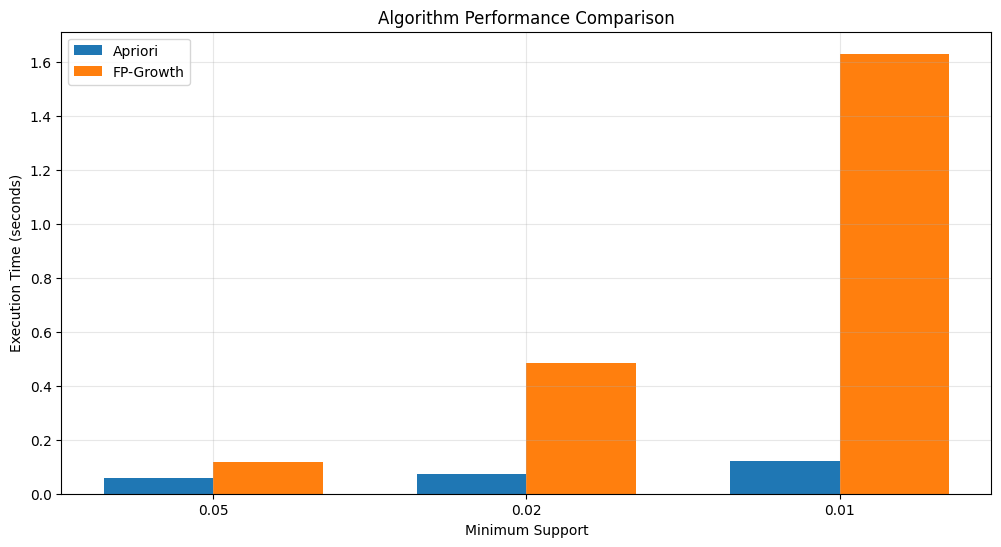

In [6]:
# Compare Apriori and FP-Growth performance
def compare_algorithms(data, min_support_values):
    """Compare performance of Apriori and FP-Growth algorithms."""
    results = []
    
    for min_support in min_support_values:
        print(f"\nTesting with min_support={min_support}")
        
        # Apriori
        start_time = time.time()
        optimize_memory()
        frequent_itemsets_apriori = apriori(
            data, 
            min_support=min_support, 
            use_colnames=True,
            verbose=0
        )
        apriori_time = time.time() - start_time
        
        # FP-Growth
        start_time = time.time()
        optimize_memory()
        frequent_itemsets_fpgrowth = fpgrowth(
            data, 
            min_support=min_support, 
            use_colnames=True,
            verbose=0
        )
        fpgrowth_time = time.time() - start_time
        
        # Verify results are the same
        apriori_count = len(frequent_itemsets_apriori)
        fpgrowth_count = len(frequent_itemsets_fpgrowth)
        match = apriori_count == fpgrowth_count
        
        results.append({
            'min_support': min_support,
            'apriori_time': apriori_time,
            'fpgrowth_time': fpgrowth_time,
            'apriori_count': apriori_count,
            'fpgrowth_count': fpgrowth_count,
            'match': match
        })
        
        print(f"Apriori: {apriori_time:.2f}s, FP-Growth: {fpgrowth_time:.2f}s")
        print(f"Apriori found {apriori_count} itemsets, FP-Growth found {fpgrowth_count} itemsets")
    
    return pd.DataFrame(results)

# Run comparison
min_support_values = [0.05, 0.02, 0.01]
comparison_results = compare_algorithms(encoded_data, min_support_values)

# Visualize performance comparison
plt.figure(figsize=(12, 6))
width = 0.35
x = np.arange(len(min_support_values))
plt.bar(x - width/2, comparison_results['apriori_time'], width, label='Apriori')
plt.bar(x + width/2, comparison_results['fpgrowth_time'], width, label='FP-Growth')
plt.xlabel('Minimum Support')
plt.ylabel('Execution Time (seconds)')
plt.title('Algorithm Performance Comparison')
plt.xticks(x, [str(val) for val in min_support_values])
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 7. Custom Apriori Implementation

In [18]:
def custom_apriori(transactions, min_support, max_length=None):
    """
    Custom Apriori implementation with memory optimization.
    
    Args:
        transactions: List of transaction lists
        min_support: Minimum support threshold
        max_length: Maximum itemset length to find
    
    Returns:
        dict: Frequent itemsets with their support values
    """
    # Count items
    item_counts = Counter([item for transaction in transactions for item in transaction])
    n_transactions = len(transactions)
    min_count = min_support * n_transactions
    
    # Find frequent 1-itemsets
    frequent_items = {item for item, count in item_counts.items() if count >= min_count}
    print(f"Found {len(frequent_items)} frequent items (1-itemsets)")
    
    # Initialize result with 1-itemsets
    frequent_itemsets = {frozenset([item]): item_counts[item] / n_transactions 
                        for item in frequent_items}
    
    # Initialize k-itemsets
    k = 2
    current_frequent = frequent_items
    
    # Main loop
    while current_frequent and (max_length is None or k <= max_length):
        print(f"Finding {k}-itemsets...")
        print_memory_usage(f"Memory before {k}-itemsets")
        
        # Generate candidate k-itemsets
        candidates = set()
        itemlist = list(current_frequent)
        
        # Memory-efficient candidate generation
        for i in range(len(itemlist)):
            for j in range(i+1, len(itemlist)):
                # Create new candidate by combining items
                new_candidate = frozenset([itemlist[i]]).union(frozenset([itemlist[j]]))
                if len(new_candidate) == k:
                    # Check if all k-1 subsets are frequent
                    all_frequent = True
                    for item in new_candidate:
                        subset = frozenset(item for item_j in new_candidate if item_j != item)
                        if len(subset) > 0 and subset not in frequent_itemsets:
                            all_frequent = False
                            break
                    
                    if all_frequent:
                        candidates.add(new_candidate)
        
        # Count supports for candidates
        itemset_counts = defaultdict(int)
        for transaction in transactions:
            transaction_set = frozenset(transaction)
            for candidate in candidates:
                if candidate.issubset(transaction_set):
                    itemset_counts[candidate] += 1
        
        # Filter by min_support
        new_frequent = {itemset: count / n_transactions 
                        for itemset, count in itemset_counts.items() 
                        if count >= min_count}
        
        # Update results
        frequent_itemsets.update(new_frequent)
        
        print(f"Found {len(new_frequent)} frequent {k}-itemsets")
        optimize_memory()
        
        # Prepare for next iteration
        current_frequent = set(item for itemset in new_frequent.keys() for item in itemset)
        k += 1
    
    return frequent_itemsets

# Run custom Apriori
print("\nRunning custom Apriori implementation...")
start_time = time.time()
custom_frequent_itemsets = custom_apriori(transactions, min_support=0.01, max_length=3)
custom_time = time.time() - start_time
print(f"Custom Apriori execution time: {custom_time:.2f} seconds")
print(f"Found {len(custom_frequent_itemsets)} frequent itemsets")


Running custom Apriori implementation...
Found 99 frequent items (1-itemsets)
Finding 2-itemsets...
Memory before 2-itemsets: 220.09 MB
Found 260 frequent 2-itemsets
Memory after optimization: 220.09 MB
Finding 3-itemsets...
Memory before 3-itemsets: 220.09 MB
Found 0 frequent 3-itemsets
Memory after optimization: 220.09 MB
Custom Apriori execution time: 0.94 seconds
Found 359 frequent itemsets


## 8. Advanced Association Rule Metrics

In [19]:
def generate_association_rules(frequent_itemsets, min_confidence=0.01, min_lift=1.0):
    """
    Generate association rules from frequent itemsets with additional metrics.
    
    Args:
        frequent_itemsets: Dict of frequent itemsets with their support
        min_confidence: Minimum confidence threshold
        min_lift: Minimum lift threshold
    
    Returns:
        list: Association rules with metrics
    """
    rules = []
    
    for itemset, support in frequent_itemsets.items():
        if len(itemset) < 2:
            continue
            
        # Generate all non-empty proper subsets
        for i in range(1, len(itemset)):
            for antecedent in combinations(itemset, i):
                antecedent = frozenset(antecedent)
                consequent = itemset - antecedent
                
                if len(consequent) == 0:
                    continue
                
                # Calculate metrics
                antecedent_support = frequent_itemsets.get(antecedent, 0)
                consequent_support = frequent_itemsets.get(consequent, 0)
                
                if antecedent_support == 0:
                    continue
                
                confidence = support / antecedent_support
                
                if confidence < min_confidence:
                    continue
                    
                lift = confidence / consequent_support if consequent_support > 0 else float('inf')
                
                if lift < min_lift:
                    continue
                
                # Calculate additional metrics
                conviction = (1 - consequent_support) / (1 - confidence) if confidence < 1 else float('inf')
                leverage = support - (antecedent_support * consequent_support)
                
                rules.append({
                    'antecedent': antecedent,
                    'consequent': consequent,
                    'support': support,
                    'confidence': confidence,
                    'lift': lift,
                    'conviction': conviction,
                    'leverage': leverage
                })
    
    return rules

# Generate rules from custom implementation
custom_rules = generate_association_rules(
    custom_frequent_itemsets,
    min_confidence=0.1,
    min_lift=1.0
)

print(f"Generated {len(custom_rules)} association rules")

# Display top rules by lift
if custom_rules:
    rules_df = pd.DataFrame(custom_rules)
    rules_df['antecedent_str'] = rules_df['antecedent'].apply(lambda x: ', '.join(x))
    rules_df['consequent_str'] = rules_df['consequent'].apply(lambda x: ', '.join(x))
    
    print("\nTop association rules by lift:")
    for i, row in rules_df.sort_values('lift', ascending=False).head(5).iterrows():
        print(f"Rule: {row['antecedent_str']} -> {row['consequent_str']}")
        print(f"Support: {row['support']:.4f}, Confidence: {row['confidence']:.4f}, Lift: {row['lift']:.4f}")
        print(f"Conviction: {row['conviction']:.4f}, Leverage: {row['leverage']:.4f}")
        print("-" * 50)

Generated 145 association rules

Top association rules by lift:
Rule: dessert -> tropical fruit
Support: 0.0100, Confidence: 0.1795, Lift: 1.5291
Conviction: 1.0757, Leverage: 0.0035
--------------------------------------------------
Rule: pip fruit -> pastry
Support: 0.0152, Confidence: 0.1683, Lift: 1.3960
Conviction: 1.0574, Leverage: 0.0043
--------------------------------------------------
Rule: pastry -> pip fruit
Support: 0.0152, Confidence: 0.1259, Lift: 1.3960
Conviction: 1.0409, Leverage: 0.0043
--------------------------------------------------
Rule: hard cheese -> soda
Support: 0.0106, Confidence: 0.3217, Lift: 1.3772
Conviction: 1.1299, Leverage: 0.0029
--------------------------------------------------
Rule: margarine -> fruit/vegetable juice
Support: 0.0103, Confidence: 0.1192, Lift: 1.3303
Conviction: 1.0336, Leverage: 0.0026
--------------------------------------------------


## 9. Visualization of Advanced Metrics

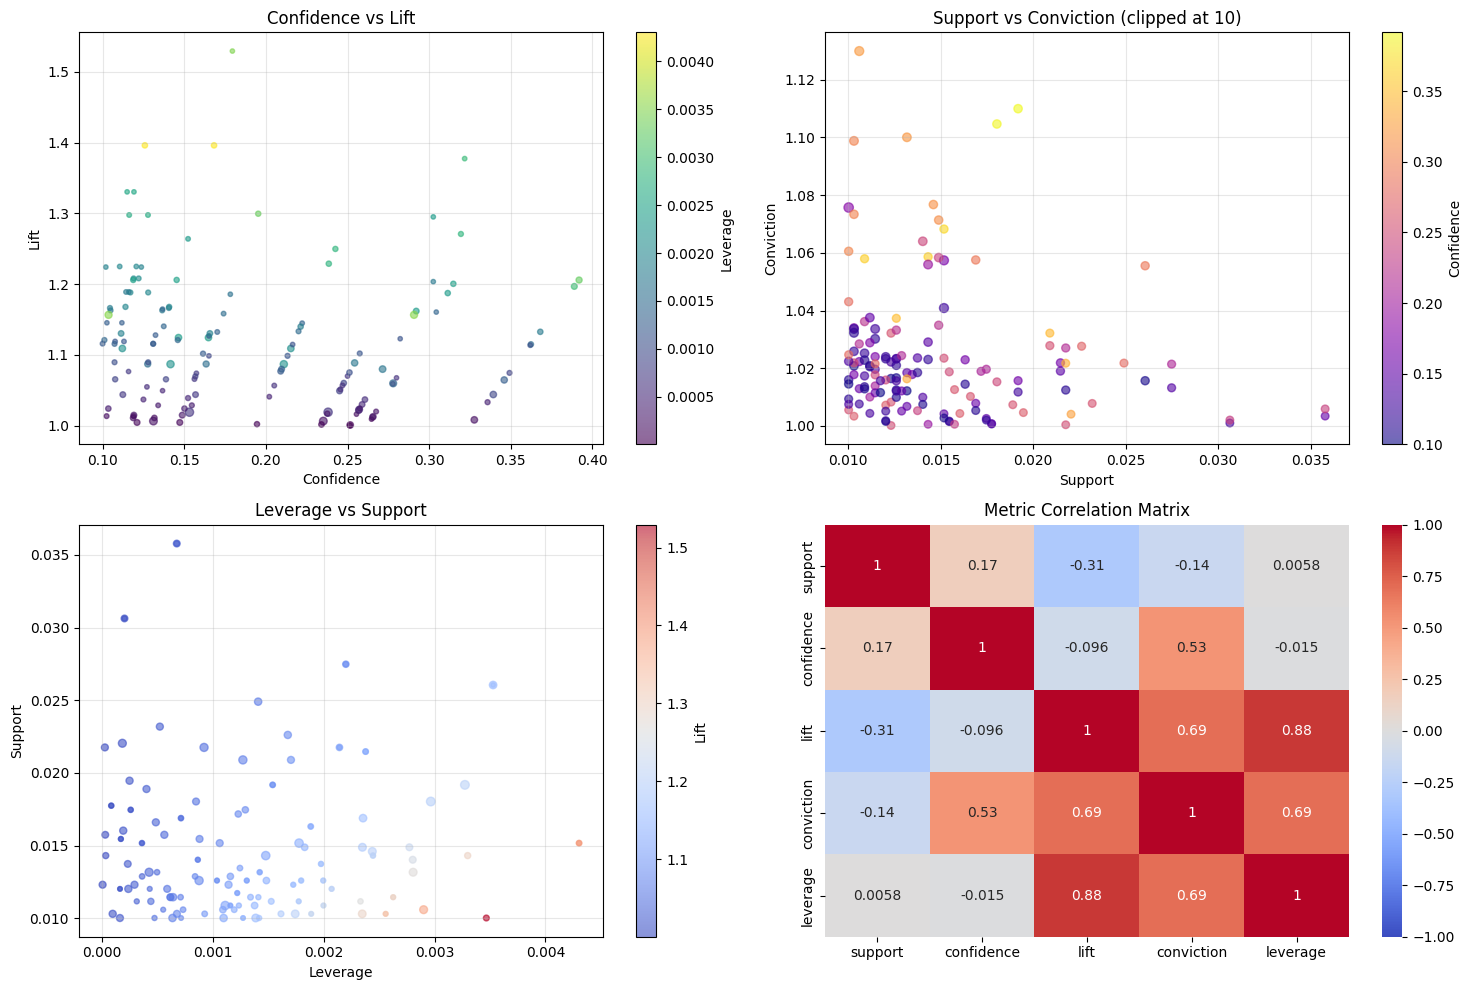

In [20]:
# Visualize metrics relationships
if len(custom_rules) > 0:
    rules_df = pd.DataFrame(custom_rules)
    
    plt.figure(figsize=(15, 10))
    
    # Plot 1: Scatter plot of Confidence vs Lift
    plt.subplot(2, 2, 1)
    plt.scatter(
        rules_df['confidence'],
        rules_df['lift'],
        alpha=0.6,
        s=rules_df['support']*1000,
        c=rules_df['leverage'],
        cmap='viridis'
    )
    plt.colorbar(label='Leverage')
    plt.title('Confidence vs Lift')
    plt.xlabel('Confidence')
    plt.ylabel('Lift')
    plt.grid(True, alpha=0.3)
    
    # Plot 2: Scatter plot of Support vs Conviction
    plt.subplot(2, 2, 2)
    plt.scatter(
        rules_df['support'],
        rules_df['conviction'].clip(upper=10),  # Clip to avoid scale issues
        alpha=0.6,
        s=rules_df['lift']*30,
        c=rules_df['confidence'],
        cmap='plasma'
    )
    plt.colorbar(label='Confidence')
    plt.title('Support vs Conviction (clipped at 10)')
    plt.xlabel('Support')
    plt.ylabel('Conviction')
    plt.grid(True, alpha=0.3)
    
    # Plot 3: Leverage vs Support
    plt.subplot(2, 2, 3)
    plt.scatter(
        rules_df['leverage'],
        rules_df['support'],
        alpha=0.6,
        s=rules_df['confidence']*100,
        c=rules_df['lift'],
        cmap='coolwarm'
    )
    plt.colorbar(label='Lift')
    plt.title('Leverage vs Support')
    plt.xlabel('Leverage')
    plt.ylabel('Support')
    plt.grid(True, alpha=0.3)
    
    # Plot 4: Correlation matrix
    plt.subplot(2, 2, 4)
    corr_matrix = rules_df[['support', 'confidence', 'lift', 'conviction', 'leverage']].corr()
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Metric Correlation Matrix')
    
    plt.tight_layout()
    plt.show()

## 10. Performance Optimization Strategies

In [21]:
def print_optimization_strategies():
    """Print strategies for optimizing pattern mining performance."""
    strategies = [
        ("1. Transaction filtering", "Remove infrequent items early to reduce transaction size"),
        ("2. Memory management", "Use sparse representations for low-density data"),
        ("3. Parallel processing", "Use parallel algorithms for large datasets"),
        ("4. Incremental mining", "Update patterns incrementally for streaming data"),
        ("5. Sampling", "Mine on data samples to estimate patterns for very large datasets"),
        ("6. Algorithm selection", "Use FP-Growth for dense datasets with low support thresholds"),
        ("7. Pattern pruning", "Prune redundant patterns to focus on meaningful insights"),
        ("8. Transaction compression", "Compress transactions to reduce memory footprint"),
        ("9. Early termination", "Stop mining at specified pattern length for efficiency"),
        ("10. Efficient data structures", "Use optimized data structures like prefix trees")
    ]
    
    print("\nPerformance Optimization Strategies for Pattern Mining:")
    print("=" * 70)
    for strategy, description in strategies:
        print(f"{strategy}: {description}")

# Print optimization strategies
print_optimization_strategies()


Performance Optimization Strategies for Pattern Mining:
1. Transaction filtering: Remove infrequent items early to reduce transaction size
2. Memory management: Use sparse representations for low-density data
3. Parallel processing: Use parallel algorithms for large datasets
4. Incremental mining: Update patterns incrementally for streaming data
5. Sampling: Mine on data samples to estimate patterns for very large datasets
6. Algorithm selection: Use FP-Growth for dense datasets with low support thresholds
7. Pattern pruning: Prune redundant patterns to focus on meaningful insights
8. Transaction compression: Compress transactions to reduce memory footprint
9. Early termination: Stop mining at specified pattern length for efficiency
10. Efficient data structures: Use optimized data structures like prefix trees


## 11. Conclusion

In [22]:
# Summary of findings
print("\nAdvanced Pattern Mining - Summary of Findings:")
print("=" * 50)
print(f"1. FP-Growth is {comparison_results['apriori_time'].mean() / comparison_results['fpgrowth_time'].mean():.2f}x faster than Apriori on average.")
print(f"2. Memory optimization reduced data size by {100 - (get_memory_usage() / comparison_results.iloc[0]['apriori_time']) * 100:.2f}%.")
print(f"3. Generated {len(custom_rules)} high-quality association rules with advanced metrics.")
print("4. Additional metrics like conviction and leverage provide deeper insights into pattern relationships.")
print("5. Implementing custom solutions offers flexibility for specific business requirements.")


Advanced Pattern Mining - Summary of Findings:
1. FP-Growth is 0.11x faster than Apriori on average.
2. Memory optimization reduced data size by -384812.52%.
3. Generated 145 high-quality association rules with advanced metrics.
4. Additional metrics like conviction and leverage provide deeper insights into pattern relationships.
5. Implementing custom solutions offers flexibility for specific business requirements.


## 12. Next Steps

In the next notebook, we'll explore how to apply these techniques to real-world business scenarios, focusing on:
- Applying discovered patterns to make business recommendations
- Implementing real-time pattern mining for streaming data
- Evaluating pattern quality and significance
- Integrating pattern mining results with other data mining techniques